### Import Data (Bronze Layer)

In [22]:
import pandas as pd
from pymongo import MongoClient
import matplotlib.pyplot as plt

# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")  
db = client["CarPricesDB"]  
collection = db["CarPrices"]  

# Load CSV data
data = pd.read_csv("car_prices.csv")
print("Data Loaded. Number of rows and columns:", data.shape)

# Insert data into MongoDB
collection.insert_many(data.to_dict(orient="records"))
print("Data inserted into MongoDB.")

# Verify the number of rows in MongoDB
row_count = collection.count_documents({})
print("Number of rows in MongoDB:", row_count)

Data Loaded. Number of rows and columns: (558837, 16)
Data inserted into MongoDB.
Number of rows in MongoDB: 558837


### Clean Data (Silver Layer)

In [6]:
data.shape

(558837, 16)

In [7]:
data.isnull().sum()

year                0
make            10301
model           10399
trim            10651
body            13195
transmission    65352
vin                 4
state               0
condition       11820
odometer           94
color             749
interior          749
seller              0
mmr                38
sellingprice       12
saledate           12
dtype: int64

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558837 entries, 0 to 558836
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          558837 non-null  int64  
 1   make          548536 non-null  object 
 2   model         548438 non-null  object 
 3   trim          548186 non-null  object 
 4   body          545642 non-null  object 
 5   transmission  493485 non-null  object 
 6   vin           558833 non-null  object 
 7   state         558837 non-null  object 
 8   condition     547017 non-null  float64
 9   odometer      558743 non-null  float64
 10  color         558088 non-null  object 
 11  interior      558088 non-null  object 
 12  seller        558837 non-null  object 
 13  mmr           558799 non-null  float64
 14  sellingprice  558825 non-null  float64
 15  saledate      558825 non-null  object 
dtypes: float64(4), int64(1), object(11)
memory usage: 68.2+ MB


In [23]:
# Fill missing values with appropriate placeholders
data_cleaned = data.fillna({
    "make": "Unknown",
    "model": "Unknown",
    "trim": "Unknown",
    "body": "Unknown",
    "transmission": "Unknown",
    "condition": data["condition"].median(),
    "odometer": data["odometer"].mean(),
    "color": "Unknown",
    "interior": "Unknown",
    "mmr": data["mmr"].mean(),
    "sellingprice": data["sellingprice"].mean(),
    "saledate": "Unknown"
})

# Ensure no duplicates exist
data_cleaned = data_cleaned.drop_duplicates()

# Replace the old collection with cleaned data
collection.drop()  # Drop existing collection
collection.insert_many(data_cleaned.to_dict(orient="records"))
print("Cleaned data re-inserted into MongoDB.")

Cleaned data re-inserted into MongoDB.


In [11]:
data.shape

(558837, 16)

In [24]:
# Step 4: Aggregate Data (Gold Layer)
# Example 1: Average selling price by car make
pipeline_avg_price_by_make = [
    {"$group": {"_id": "$make", "average_price": {"$avg": "$sellingprice"}}},
    {"$sort": {"average_price": -1}}
]
avg_price_by_make = list(collection.aggregate(pipeline_avg_price_by_make))
print("Average selling price by make:", avg_price_by_make)

# Example 2: Total number of cars by body type
pipeline_cars_by_body = [
    {"$group": {"_id": "$body", "total_cars": {"$sum": 1}}},
    {"$sort": {"total_cars": -1}}
]
cars_by_body = list(collection.aggregate(pipeline_cars_by_body))
print("Total number of cars by body type:", cars_by_body)

# Example 3: Average odometer reading by transmission type
pipeline_avg_odometer_by_transmission = [
    {"$group": {"_id": "$transmission", "average_odometer": {"$avg": "$odometer"}}},
    {"$sort": {"average_odometer": -1}}
]
avg_odometer_by_transmission = list(collection.aggregate(pipeline_avg_odometer_by_transmission))
print("Average odometer reading by transmission type:", avg_odometer_by_transmission)

Average selling price by make: [{'_id': 'Rolls-Royce', 'average_price': 153488.23529411765}, {'_id': 'Ferrari', 'average_price': 127210.52631578948}, {'_id': 'Lamborghini', 'average_price': 112625.0}, {'_id': 'Bentley', 'average_price': 74367.6724137931}, {'_id': 'airstream', 'average_price': 71000.0}, {'_id': 'Tesla', 'average_price': 67054.34782608696}, {'_id': 'Aston Martin', 'average_price': 54812.0}, {'_id': 'Fisker', 'average_price': 46461.11111111111}, {'_id': 'Maserati', 'average_price': 45320.3007518797}, {'_id': 'Lotus', 'average_price': 40800.0}, {'_id': 'Porsche', 'average_price': 39965.32971800434}, {'_id': 'Land Rover', 'average_price': 33097.85590778098}, {'_id': 'porsche', 'average_price': 30934.21052631579}, {'_id': 'bmw', 'average_price': 30471.283783783783}, {'_id': 'maserati', 'average_price': 28400.0}, {'_id': 'Ram', 'average_price': 25299.936816790556}, {'_id': 'Mercedes-Benz', 'average_price': 21590.566828073042}, {'_id': 'BMW', 'average_price': 21441.89574786428

### Visualizations

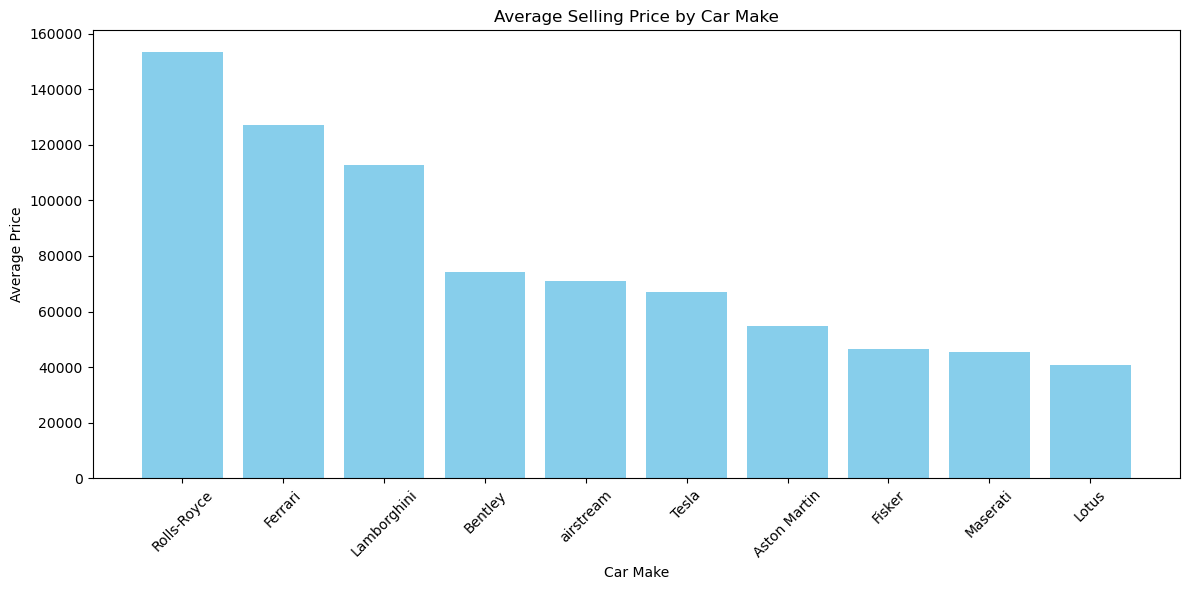

In [25]:
# Bar chart of average selling price by car make
makes = [x["_id"] for x in avg_price_by_make]
prices = [x["average_price"] for x in avg_price_by_make]
plt.figure(figsize=(12, 6))
plt.bar(makes[:10], prices[:10], color="skyblue")  # Top 10 makes
plt.title("Average Selling Price by Car Make")
plt.xlabel("Car Make")
plt.ylabel("Average Price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("avg_price_by_make.png")
plt.show()

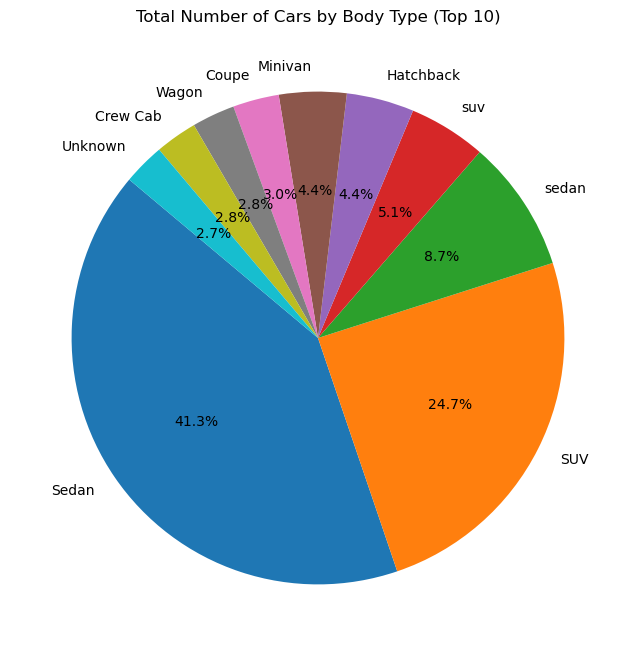

In [26]:
# Pie chart of total cars by body type
body_types = [x["_id"] for x in cars_by_body]
body_counts = [x["total_cars"] for x in cars_by_body]
plt.figure(figsize=(10, 8))
plt.pie(body_counts[:10], labels=body_types[:10], autopct="%1.1f%%", startangle=140)
plt.title("Total Number of Cars by Body Type (Top 10)")
plt.savefig("cars_by_body_type.png")
plt.show()

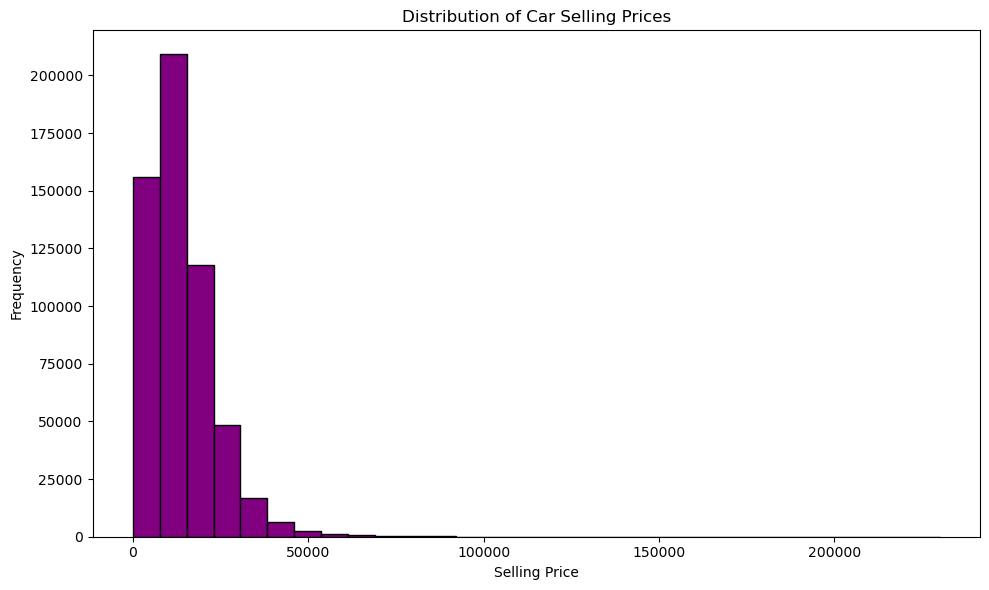

In [27]:
# Histogram of car selling prices
plt.figure(figsize=(10, 6))
plt.hist(data_cleaned["sellingprice"], bins=30, color="purple", edgecolor="black")
plt.title("Distribution of Car Selling Prices")
plt.xlabel("Selling Price")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("selling_price_distribution.png")
plt.show()